In [1]:
#Adapted from https://github.com/ericcropp/Impact-T_Examples/blob/main/FACET-II_Impact_Bmad/Impact_Bmad.ipynb
from UTILITY_quickstart import *


from distgen import Generator
from impact import Impact, run_impact_with_distgen, evaluate_impact_with_distgen
from impact.autophase import autophase_and_scale
import copy
import yaml

import impact

In [2]:
filePath = os.getcwd()
os.environ['FACET2_LATTICE'] = filePath
print('Environment set to: ', environ['FACET2_LATTICE']) 

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao


In [3]:
impactFolderPath = filePath+"/impact/"

In [4]:
GFILE = impactFolderPath+'distgen.yaml' # Distgen input file
YFILE = impactFolderPath+'ImpactT.yaml' # To be created based on template and updated for final run
YFILE_TEMPLATE = impactFolderPath+'ImpactT-template.yaml' #Initial settings

In [5]:
L0AF_E_Gain=62924849.46502216 # Calculated L0AF energy gain from January 2024 nominal power readbacks
#L0BF_E_Gain=60473730.43463376 # Calculated L0BF energy gain from January 2024 nominal power readbacks
sim_sol_conv=1.6 #Convert from PV value to T/m (simulation input)
L0AF_Phase=0 #L0AF phase; 0 is max E phase

In [6]:
#Impact settings
SETTINGS0 = {
    #'numprocs':(len(os.sched_getaffinity(0)))-1, #Number of available cores, minus one (jupyter is running in one core)
    'numprocs':1,
    'header:Nx':32,
    'header:Ny':32,  
    'header:Nz':32, 
    'stop_1:s':4.2,
    'distgen:n_particle':1e5,
    'GUNF:theta0_deg':26.8-90.5,#30 degrees-adjustment for phase def.
    'GUNF:rf_field_scale': 123/2.44885*1e6,
    'SOL10111:solenoid_field_scale':-0.41/sim_sol_conv,
    #'PR10241:sample_frequency':1,
    #'workdir':os.path.expandvars('~/'),
    #'command': '/opt/homebrew/anaconda3/envs/bmadclone/bin/ImpactTexe',    
    #'command_mpi': '/sdf/home/c/cropp/conda/envs/xopt/bin/ImpactTexe-mpi',
    # 'mpi_run':'salloc --partition milano --account ad:ard-online -N 1 -n {nproc} /usr/lib64/openmpi/bin/mpirun -n {nproc} {command_mpi}'
    #'mpi_run':'/usr/lib64/openmpi/bin/mpirun --oversubscribe -n {nproc} {command_mpi}'
}


In [7]:
I = Impact.from_yaml(YFILE_TEMPLATE)
G = Generator(GFILE)

In [8]:
def update_impact(I,settings=None,
               impact_config=None,
               verbose=False):
    
    I.verbose=verbose
    if settings:
        for key in settings:
            val = settings[key]
            if not key.startswith('distgen:'):
               # Assume impact
                if verbose:
                    print(f'Setting impact {key} = {val}')          
                I[key] = val                
   
    return I
    
I=update_impact(I,SETTINGS0)

In [9]:
I2=copy.deepcopy(I)

P0 = pmd_beamphysics.single_particle(pz=1e-15, z=1e-15)


I2.numprocs=1
t=I2.track(P0,s=0.9)

E=t['mean_energy']
print(E)

6277840.0749794515


In [10]:
I['L0AF_scale']['rf_field_scale']=30e6
I['L0AF_phase']['theta0_deg']=29
I.numprocs=1

target_L0AF=E+L0AF_E_Gain

print(target_L0AF)

res_L0AF = impact.autophase.autophase_and_scale(I, phase_ele_name='L0AF_phase', scale_ele_name='L0AF_scale', target=target_L0AF, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)


69202689.54000162
Copied initial Impact object. 
Phasing L0AF_phase by changing theta0_deg
Scaling L0AF_scale by changing rf_field_scale
Bounds: 1.058398, 4.101254 m
Tracking initial particles to s = 1.058398
Initial particle:  1.05790393743 6277840.0749794515
Disabling GUNF
Disabling SOL10111
Disabling L0BF_entrance
Disabling L0BF_body_1
Disabling L0BF_body_2
Disabling L0BF_exit
Default brent2 algorithm
Phase: 180, Scale: 10000000.0, 13.884908067191025 MeV
Phase: 180, Scale: 10000000.0, 13.884908067191025 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 19.472839721833132 MeV
Phase: 264.9844890561601, Scale: 10000000.0, 9.13965596507301 MeV
Phase: 42.49223440298533, Scale: 10000000.0, 19.47284119061983 MeV
Phase: 264.9844709438398, Scale: 10000000.0, 9.139652577562334 MeV
Phase: 222.4922627871657, Scale: 10000000.0, 9.516210148212714 MeV
Phase: 127.47670402554945, Scale: 10000000.0, 8.61015493402449 MeV
Phase: 333.73836524477724, Scale: 10000000.0, 24.070882060245747 MeV
Phase: 291.24

In [11]:
I['L0AF_phase']['theta0_deg']=I['L0AF_phase']['theta0_deg']-L0AF_Phase

In [12]:
with open(YFILE_TEMPLATE, 'r') as file:
    impact_input = yaml.safe_load(file)

In [13]:
impact_input['group']['L0AF_phase']['value']=float(I['L0AF_phase']['theta0_deg'])
impact_input['group']['L0AF_scale']['value']=float(I['L0AF_scale']['rf_field_scale'])

In [14]:
with open(YFILE, 'w') as file:
    yaml.dump(impact_input, file)

In [15]:
#NMM overwrite; replace solenoid scan
t = -0.4185

In [16]:
def update_distgen(G,settings=None,verbose=False):
    G.verbose=verbose
    if settings:
        for key in settings:
            val = settings[key]
            if key.startswith('distgen:'):
                key = key[len('distgen:'):]
                if verbose:
                    print(f'Setting distgen {key} = {val}')
                G[key] = val
            
    
    # Get particles
    
    return G
    
G=update_distgen(G,SETTINGS0,verbose=True)
G.input
G.run()
P = G.particles
I.initial_particles = P

Setting distgen n_particle = 100000.0
Distribution format: None
Output file: None

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 1600 pC.
   Number of macroparticles: 100000.
   xy distribution: 2D File PDF
      2D pdf file: /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/impact/VCC.jpeg
      min_x = -2.808 mm, max_x = 2.808 mm
      min_y = -2.808 mm, max_y = 2.808 mm
   t distribution: Gaussian
      avg_t = 0 ps, sigma_t = 1.170 ps
      Left n_sigma_cutoff = 3, Right n_sigma_cutoff = -3
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 452.106 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 452.106 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 452.106 eV/c
   Shifting avg_x = -0.454987 mm -> -0.454987 mm
   Scaling sigma_x = 1.01005 mm -> 1.01005 mm
   Shifting avg_y = 0.301811 mm -> 0.301811 mm
   Shifting avg_px = -0.0670598 eV/c -> 0 eV/c
   Scaling sigma_px = 452.074 eV/c -> 452.106 eV/c
  

In [17]:
I.numprocs=SETTINGS0['numprocs']

I['SOL10111:solenoid_field_scale']=t/sim_sol_conv
print(I)

================ Impact-T Summary ================    
10000 particles
1 bunch of electrons
total charge: 249.99999999999997 pC
Distribution type: read
Cathode start at z = 0 m
   emission time: 1.4e-11 s
   image charges neglected after z = 0.02 m
Processor domain: 1 x 1 = 1 CPUs
Space charge grid: 32 x 32 x 32
Maximum time steps: 1000000
Reference Frequency: 2856000000.0 Hz
Initial reference time: 0.0 s
Simulation starting from the beginning
Impact-T configured in /var/folders/3j/4b_6gm4j44z6mpdlh3f3ggjc0000gn/T/tmp1ka6766b


In [18]:
I.workdir = impactFolderPath
I.verbose=True
I.run()

Running Impact-T in /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/impact/tmp9e8873hq
/opt/homebrew/anaconda3/envs/bmadclone/bin/ImpactTexe
writing 100000 particles to /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/impact/tmp9e8873hq/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 100000 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 7.014178661711723e-12 according to initial particles
Cathode start: Replaced Tini with -3.507963193747037e-12 according to initial particles
Setting total charge to 1.6000000000000005e-09 C
 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code: V2.3.1
 ! Copyright of The Regents of the University of California
 !-----------------------------------------------------------
 nblem:           28          28
 pass setting up lattice...
 check randomness:       

In [19]:
P1 = I.particles['L0AFEND'].copy()
# P1 = P1.resample(100_000)
P1.drift_to_z()
P1.z[:] = 0
P1.t[:] -= P1['mean_t']
P1['mean_energy']

P1.write(filePath+"/beams/"+"ImpactBeam.h5")

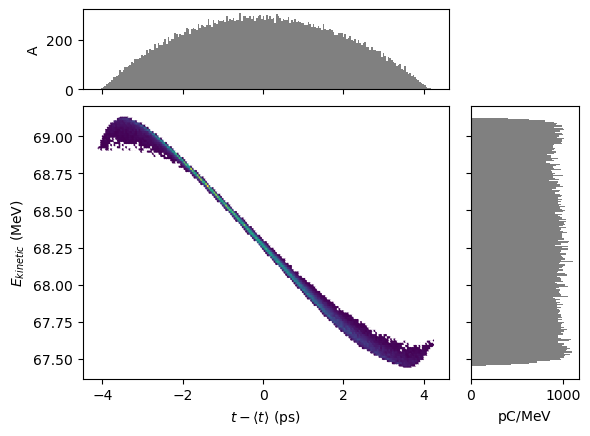

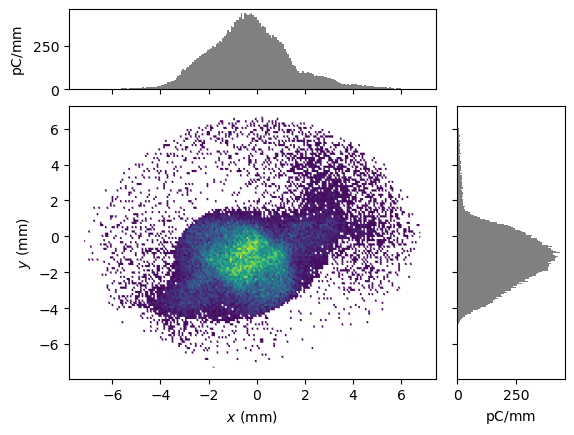

In [20]:
P1.plot('delta_t','kinetic_energy',bins=200)
P1.plot('x','y',bins=200)

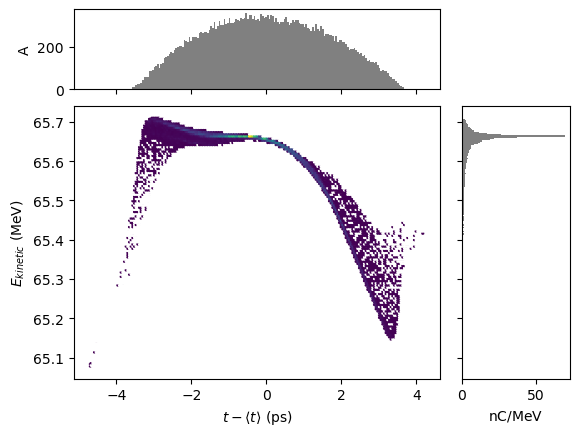

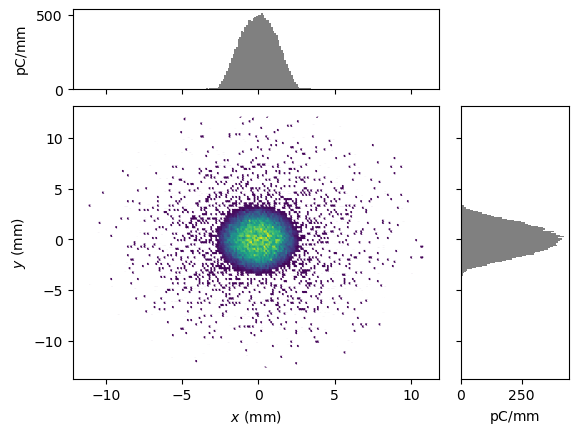

In [21]:
twoBunchDriver = ParticleGroup(filePath+'/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly_2023-05-16InjectorMatch.h5')
twoBunchDriver.plot('delta_t','kinetic_energy',bins=200)
twoBunchDriver.plot('x','y',bins=200)